In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# max_devices_per_cell is also max number of rows in circuit files in the training set
max_devices_per_cell = 351; 
# feature_per_device is different from max number of cols (14) in circuit files in training set
feature_per_device   = 5; 
feature_indices = (0,2,5,8,11)

In [3]:
def load_one_cell(cell_file):
    cell_cols = 14
    cell_data = np.zeros(shape=(max_devices_per_cell, cell_cols), dtype=np.float32)
    cell_mat  = np.loadtxt(cell_file, dtype=np.float32, ndmin=2)
    nrows     = cell_mat.shape[0]
    ncols     = cell_mat.shape[1]
    cell_data[:nrows, :ncols] = cell_mat
    cell_data = cell_data[:, feature_indices]
    return cell_data

In [4]:
def load_cells(folder):
  #Load the data for a single label.
  cell_files = os.listdir(folder)
  dataset = np.zeros(shape=(len(cell_files), max_devices_per_cell, feature_per_device),
                         dtype=np.float32)
  cell_index = 0
  for cell in cell_files:
    cell_file = os.path.join(folder, cell)
    try:
      cell_data = load_one_cell(cell_file)

      cell_rows = cell_data.shape[0]
      cell_cols = cell_data.shape[1]
      dataset[cell_index, :cell_rows, :cell_cols] = cell_data

      cell_index = cell_index + 1
    except IOError as e:
      print('Could not read:', cell_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:cell_index, :, :]

  print(os.path.basename(folder), ': shape=', dataset.shape, ', Mean=', np.mean(dataset), ', sigma=', np.std(dataset))
  return dataset

In [5]:
current_folder = globals()['_dh'][0]
comb_dataset = load_cells(os.path.join(current_folder,'COMB'))
sqnc_dataset = load_cells(os.path.join(current_folder,'SEQ'))

COMB : shape= (10, 351, 5) , Mean= 0.0988604 , sigma= 1.033829
SQNC : shape= (10, 351, 5) , Mean= 1.4900855 , sigma= 5.138047


In [6]:
labels = np.asarray([[1.0, 0.0] if (i<comb_dataset.shape[0]) else [0.0, 1.0] for i in range(comb_dataset.shape[0]+sqnc_dataset.shape[0])])

In [7]:
np.random.shuffle(comb_dataset)
np.random.shuffle(seq_dataset)

In [8]:
# Create a combined dataset
dataset = np.append(comb_dataset, seq_dataset, axis=0)	  

dataset = dataset.reshape((-1, max_devices_per_cell*feature_per_device))

In [9]:
dataset.shape

(20, 1755)

In [10]:
data_mean = 0;
data_std  = (np.max(dataset)-np.min(dataset));

def normalize(d, mean, std):
    return (d - mean) / std

dataset = normalize(dataset, data_mean, data_std)

In [11]:
    train_index = int(dataset.shape[0]*0.8)
    Xtrain = dataset[:train_index, :]
    Ytrain = labels[:train_index,:]
    Xtest = dataset[train_index:,:]
    Ytest = labels[train_index:,:]	

In [12]:
Xtrain.shape

(16, 1755)

In [13]:
from keras.models import Sequential
from keras.layers import Dense
model=Sequential()

model.add(Dense(16,activation='softmax',input_shape=(1755,)))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam',loss='mse',metrics=['acc'])

Using TensorFlow backend.
W1122 11:51:34.890354 14092 deprecation_wrapper.py:119] From C:\Users\NITISH\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1122 11:51:34.928350 14092 deprecation_wrapper.py:119] From C:\Users\NITISH\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1122 11:51:34.933333 14092 deprecation_wrapper.py:119] From C:\Users\NITISH\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1122 11:51:35.002310 14092 deprecation_wrapper.py:119] From C:\Users\NITISH\Miniconda3\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                28096     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 28,130
Trainable params: 28,130
Non-trainable params: 0
_________________________________________________________________


In [15]:
history=model.fit(Xtrain,Ytrain, epochs=100,validation_data=(Xtest, Ytest))

W1122 11:51:35.406075 14092 deprecation_wrapper.py:119] From C:\Users\NITISH\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1122 11:51:35.525988 14092 deprecation_wrapper.py:119] From C:\Users\NITISH\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 16 samples, validate on 4 samples
Epoch 1/100
16/16 [==============================] - 0s 21ms/step - loss: 0.2630 - acc: 0.3750 - val_loss: 0.2015 - val_acc: 1.0000
Epoch 2/100
16/16 [==============================] - 0s 311us/step - loss: 0.2611 - acc: 0.3750 - val_loss: 0.1977 - val_acc: 1.0000
Epoch 3/100
16/16 [==============================] - 0s 312us/step - loss: 0.2590 - acc: 0.3750 - val_loss: 0.1939 - val_acc: 1.0000
Epoch 4/100
16/16 [==============================] - 0s 562us/step - loss: 0.2567 - acc: 0.3750 - val_loss: 0.1900 - val_acc: 1.0000
Epoch 5/100
16/16 [==============================] - 0s 375us/step - loss: 0.2544 - acc: 0.3750 - val_loss: 0.1862 - val_acc: 1.0000
Epoch 6/100
16/16 [==============================] - 0s 250us/step - loss: 0.2521 - acc: 0.3750 - val_loss: 0.1825 - val_acc: 1.0000
Epoch 7/100
16/16 [==============================] - 0s 312us/step - loss: 0.2499 - acc: 0.3750 - val_loss: 0.1789 - val_acc: 1.0000
Epoch 8/100
16/16 [========

Epoch 62/100
16/16 [==============================] - 0s 313us/step - loss: 0.1636 - acc: 1.0000 - val_loss: 0.0900 - val_acc: 1.0000
Epoch 63/100
16/16 [==============================] - 0s 375us/step - loss: 0.1625 - acc: 1.0000 - val_loss: 0.0897 - val_acc: 1.0000
Epoch 64/100
16/16 [==============================] - 0s 375us/step - loss: 0.1615 - acc: 1.0000 - val_loss: 0.0894 - val_acc: 1.0000
Epoch 65/100
16/16 [==============================] - 0s 438us/step - loss: 0.1604 - acc: 1.0000 - val_loss: 0.0891 - val_acc: 1.0000
Epoch 66/100
16/16 [==============================] - 0s 312us/step - loss: 0.1594 - acc: 1.0000 - val_loss: 0.0889 - val_acc: 1.0000
Epoch 67/100
16/16 [==============================] - 0s 312us/step - loss: 0.1583 - acc: 1.0000 - val_loss: 0.0887 - val_acc: 1.0000
Epoch 68/100
16/16 [==============================] - 0s 312us/step - loss: 0.1573 - acc: 1.0000 - val_loss: 0.0884 - val_acc: 1.0000
Epoch 69/100
16/16 [==============================] - 0s 437us

In [18]:
print(history.history['acc'])

[0.625, 0.625, 0.625, 0.6875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


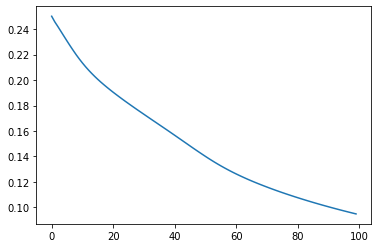

In [17]:
plt.plot(history.history['loss'])
plt.show()